# はじめに
ニューラルネットワークの予測の不確実性を算出する手法を検証します。

### 概要
- 連続値を予測する回帰のためのニューラルネットワークを構築
- deep ensembleで予測の不確実性を算出


# deep ensemble
異なる初期値で複数のニューラルネットワークを学習し、それらの予測の分散を予測の不確実性として使用する手法です。  

### ベイズ推論  
通常のニューラルネットワークでは、出力は変数$\hat{y}$ですが、ベイズ推論ではラベル$y$の事後分布$p(y|x)$を考えます。  
事後分布が尖った形になっている場合は予測の不確実性が低く、裾が広い場合は不確実性が高いことになります。  

ラベルの事後分布は、パラメータの分布$p(\theta)$を考え、積分で$\theta$を消去することで求めます。  
$$
p(y|x) = \int p(y|x, \theta)p(\theta) {\rm d}\theta
$$

### 不確実性の算出  
deep ensembleでは、異なる初期値で学習したニューラルネットワークを、パラメータの分布$p(\theta)$からのサンプリングと考えます。  
異なる初期値でn個のニューラルネットワーク$\{f_{\theta_1}, ..., f_{\theta_n}\}$の学習を行い、それらの予測の平均を事後分布の期待値、分散を予測の不確実性として用います。  

$$
\mu(y) = \frac{1}{n}\sum_{i=1}^n f_{\theta_i}(x)
$$
$$
{\rm Var}(y) = \frac{1}{n}\sum_{i=1}^n f_{\theta_i}(x)^T f_{\theta_i}(x) - \mu(y)^T \mu(y)
$$





# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  
[Google Colaboratory](https://colab.research.google.com/?hl=ja)で実行した際の例になります。

In [2]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
!nvidia-smi

Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
PyTorch: 2.0.1+cu118
Sat Jul  1 06:06:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
         

### 3. データセットの作成  
sinカーブに従うデータを作成します。  
ただし、学習には[-1,1]の範囲のデータは使用しません。


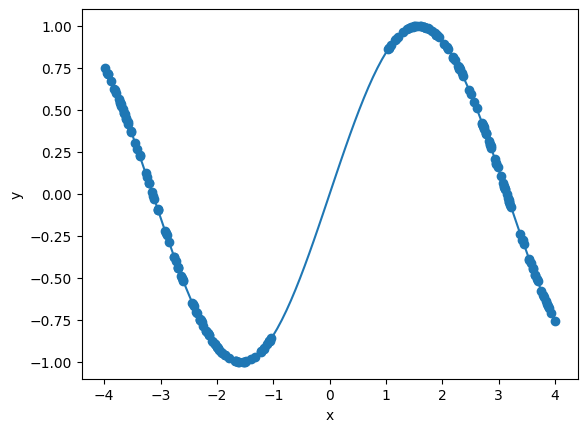

In [3]:
def make_dataset(seed, plot=0):
    np.random.seed(seed)

    x_true = np.linspace(-4, 4, 100)
    y_true = np.sin(x_true)

    x = np.concatenate([np.random.uniform(-4, -1, 100), np.random.uniform(1, 4, 100)])
    y = np.sin(x)

    # データをPyTorchのテンソルに変換
    x = torch.from_numpy(x).float().view(-1, 1)
    y = torch.from_numpy(y).float().view(-1, 1)
    x_true = torch.from_numpy(x_true).float().view(-1, 1)

    # グラフを描画
    if plot == 1:
        plt.plot(x_true, y_true)
        plt.scatter(x, y)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

    dataset = torch.utils.data.TensorDataset(x, y)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    return data_loader

_ = make_dataset(0, plot=1)

### 4. ニューラルネットワークの定義  
今回は3層の全結合ニューラルネットワークを用います。

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### 5. 学習
異なるデータセット、初期値で10個のニューラルネットワークの学習を行います。  


In [11]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model_list = []

for i in range(10):
    data_loader = make_dataset(i)
    model = Net()
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # 学習
    model.train()
    num_epochs = 1000
    for epoch in range(num_epochs):
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # 順伝播と損失の計算
            y_pred = model(inputs)
            loss = criterion(y_pred, targets)

            # 勾配の初期化と逆伝播
            optimizer.zero_grad()
            loss.backward()

            # パラメータの更新
            optimizer.step()
    model_list.append(model)


### 6. 予測
個々のニューラルネットワークの予測結果、予測の平均、標準偏差を描画します。

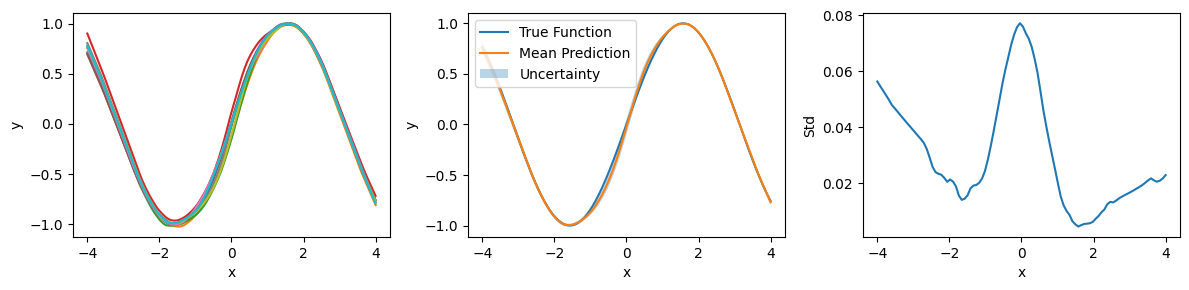

In [14]:
x_true = np.linspace(-4, 4, 100)
y_true = np.sin(x_true)
x_true = torch.from_numpy(x_true).float().view(-1, 1)

plt.figure(figsize=(12,3))
plt.subplot(131)
y_preds = []
for i in range(len(model_list)):
    model = model_list[i]
    model.eval()
    x_true = x_true.to(device)
    with torch.no_grad():
        y_pred = model(x_true)
    y_preds.append(y_pred.to('cpu').detach().numpy())

    x_true = x_true.to('cpu')
    plt.plot(x_true, y_preds[-1], label=f'model {i}')

plt.xlabel('x')
plt.ylabel('y')
y_preds = np.array(y_preds)
y_mean = np.mean(y_preds, axis=0)
y_std = np.std(y_preds, axis=0)


plt.subplot(132)
plt.plot(x_true, y_true, label='True Function')
plt.plot(x_true, y_mean, label='Mean Prediction')
plt.fill_between(x_true.flatten(), y_mean.flatten() - y_std.flatten(), y_mean.flatten() + y_std.flatten(), alpha=0.3, label='Uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(133)
plt.plot(x_true, y_std)
plt.xlabel('x')
plt.ylabel('Std')

plt.tight_layout()
plt.show()

# おわりに

### 今回の結果
deep ensembleで求めた予測の不確実性は、x最小値および最大値付近とデータが含まれない[-1,1]の範囲で大きくなっています。  
データ数が少なく、予測が不確実と考えられる領域と、予測の標準偏差が大きい領域が一致しているため、想定通り予測の不確実性が算出できていると考えられます。  

### 次にやること
予測の不確実性を算出する他の手法も検証したいと思います。  

### 参考資料
- B. Lakshminarayanan et al., Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles, NeurIPS, 2017.
- PyTorch Quickstart  
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

